## Laboratorium 8.1


## Metody wykrywania ruchu: przepływ optyczny (_optical flow_)

### Wstęp

Na poprzednich laboratoriach poznaliśmy podstawowe metody przetwarzania obrazów, a więc dwuwymiarowych sygnałów przestrzennych. Wiele z tych metod działa także dla (trójwymiarowego) sygnału wideo, jeśli - nieco naiwnie - potraktujemy go jako po prostu sekwencję niezależnych obrazów.

W tej liście wykorzystasz także dziedziną czasową do przetwarzania sygnału. Podstawowa intuicja polega na tym, że jeśli jakiś rejon obrazu przesunął się w czasie, to prawdopodobnie ma on inne _znaczenie_ niż rejon, który pozostał w tym samym miejscu, lub przesunął w innym kierunku czy z inną szybkością. Jeśli zatem jesteśmy w stanie wykryć to przesunięcie - czyli po prostu _ruch_ - to otrzymamy pewną informację o zawartości obrazu (wideo). Na przykład, będziemy w stanie oddzielić poruszające się obiekty od stacjonarnego tła, albo oddzielić inaczej poruszające się obiekty.

Jedną z najpowszechniejszych metodą do automatycznej detekcji ruchu jest znana Ci już z wykładu metoda przepływu optycznego (ang. _optical flow_). Namawiam też do lektury [artykułu z dokumentacji OpenCV](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html), zwłaszcza sekcji _Lucas-Kanade_ oraz _Dense Optical Flow_. Analizując kod metody, poświęć chwilę na zrozumienie mapowania wyników do prezentowanego obrazu w przestrzeni HSV.

Wiedzieć należy na pewno, że istnieją dwie główne odmiany metody przepływu optycznego:,
* przepływ gęsty (_dense_) - gdzie przesunięcie pomiędzy klatkami określane jest dla każdego piksela (na tej metodzie skupia się niniejsza część listy),
* przepływ rzadki (_sparse_) - gdzie ruch wykrywany jest tylko dla pewnego zbioru punktów zainteresowania w obrębie obrazu (przebadasz ją w drugiej części listy).

W ramach obu odmian występuje pewna liczba konkretnych metod obliczeniowych, w zależności od konkretnego podejścia do rozwiązywania równania ruchu. Na tych zajęciach wykorzystamy [algorytm Farnebacka](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) - głównie dlatego, że jego gotowa implementacja znajduje się w pakiecie OpenCV.

### Podejście

Większość algorytmów optical flow operuje na parze klatek, znajdując wektory translacji pomiędzy rejonami z jednej i drugiej. Jeśli więc interesuje nas przetwarzanie ciągłego strumienia wideo, praca przebiegać będzie na zasadzie dwuelementowej kolejki, tzn. zawsze patrzymy na klatkę obecną $I(x,y,t)$ i poprzednią $I(x,y,t-1)$.

OpenCV oferuje banalnie prosty a zarazem potężny interfejs do obsługi strumieni wideo: [`cv2.VideoCapture`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html), za pomocą którego w ten sam sposób możemy obsługiwać pliki wideo w różnym kodowaniu, urządzenia wideo (np. kamerkę w laptopie) czy nawet wideo w protokole IP (choć występują pewne różnice z punktu widzenia użycia, jeśli korzystamy z zasobu sprzętowego działającego w czasie rzeczywistym). Idea jest prosta:
* tworzymy obiekt `cv2.VideoCapture` w odpowiedni sposób,
* pobieramy poszczególne klatki za pomocą metody [`VideoCapture::read`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).

Metoda `read` wykonuje całą pracę (odczytanie danych, dekodowanie strumienia wideo) i zwraca klatkę jako obraz w standardowym formacie OpenCV (a także flagę, czy w ogóle udało się pozyskać dane - krotka (flaga, klatka)). Zatem, aby pozyskać pierwszą klatkę z pliku wideo wystarczy:
```python
vid = cv2.VideoCapture("back.mp4")
r, frame = vid.read()
```

Drobnym ograniczeniem VideoCapture jest to, że nie ma możliwości cofnięcia się do poprzednio pobranej klatki (co jest naturalne w przypadku korzystania z fizycznego urządzenia do akwizycji, a może trochę mniej gdy czytamy z pliku). Jeśli potrzebny jest powrót do początku pliku wideo, niestety konieczne jest zamknięcie strumienia (`VideoCapture::release`) i ponowne otwarcie (`::open`).

Aby obliczyć (gęsty) przepływ optyczny pomiędzy dwiema klatkami, wykorzystamy algorytm Farnebacka, zaimplementowany w OpenCV w funkcji [`cv2.calcOpticalFlowFarneback`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Przyjmuje ona parę obrazów **w skali szarości**, opcjonalny argument `flow` (rozwiązanie można zainicjować poprzednio wyliczonym przepływem, jeśli nim dysponujemy), a następnie szereg parametrów sterujących metodą; m.in. można wykorzystać piramidyzację obrazów (rekomendowane `pyr_size` $=3$) czy określić rozmiar okna detekcji `winsize`. Sensowne pierwsze wartości dla argumentów podane są w dokumentacji.

Algorytm Farnebacka zwraca przepływ w formie obrazu o wymiarach przestrzennych równych obrazom wejściowym i dwóch kanałach, zawierających przesunięcie odpowiednio w osi $x$ i $y$. Można więc przetwarzać te dane dalej, np. obliczając kąt przesunięcia czy całkowitą odległość (i dalej, np. określić prędkość ruchu) - vide np. `cv2.cartToPolar`.

---

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Zadanie 1

#### Zadanie 1a
Otwórz wideo `kick.mp4` lub `back.mp4` i pobierz kilka klatek. Przewiń do interesującego Cię momentu - tak, aby uzyskać dwie klatki, na których widać ruch (pro-tip: znając framerate materiału (~25fps) i czas, w którym rozpoczyna się interesujący fragment, możesz w pętli "skonsumować" odpowiednią ilość klatek).  
Wykorzystaj algorytm Farnebacka do obliczenia przepływu pomiędzy klatkami. Wynik zaprezentuj w postaci obrazu całkowitego przesunięcia. W zależności od wybranego momentu w wideo, możesz spodziewać się uzyskania wyraźnych obszarów.

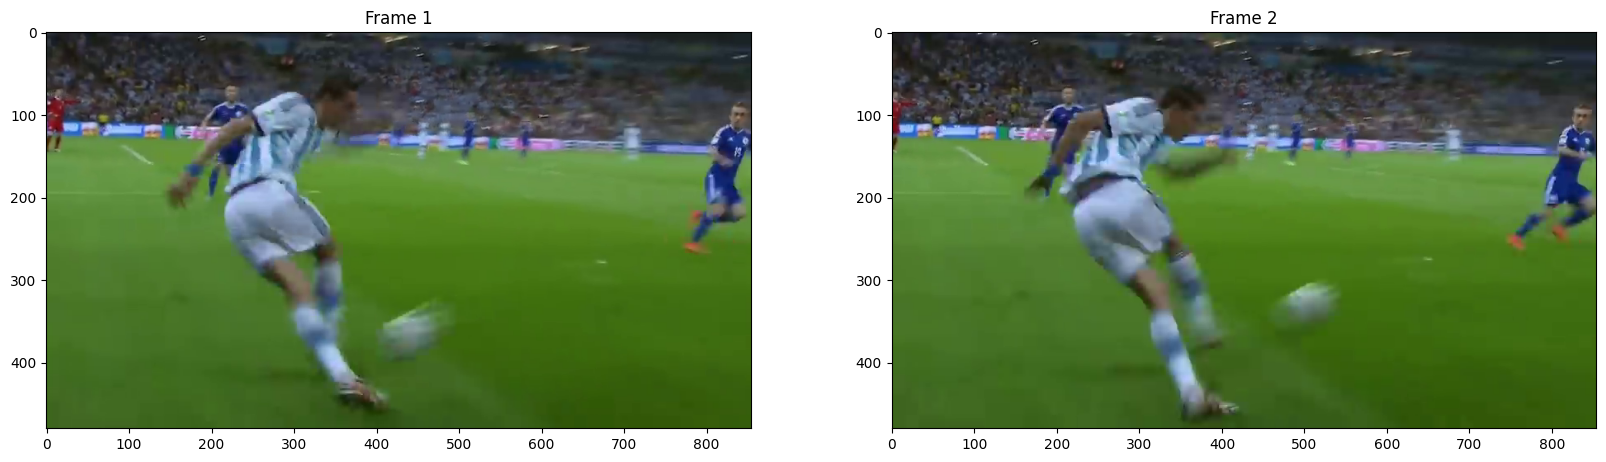

In [4]:
cap = cv2.VideoCapture("dane/back.mp4")
for _ in range(30):
    r, frame = cap.read()

_, f1 = cap.read()
_, f2 = cap.read()

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(f1[..., ::-1])
plt.title("Frame 1")
plt.subplot(1, 2, 2)
plt.imshow(f2[..., ::-1])
plt.title("Frame 2")
plt.show()

In [5]:
f1_gray = cv2.cvtColor(f1, cv2.COLOR_BGR2GRAY)
f2_gray = cv2.cvtColor(f2, cv2.COLOR_BGR2GRAY)

In [6]:
flow = cv2.calcOpticalFlowFarneback(
    prev=f1_gray,
    next=f2_gray,
    flow=None,
    pyr_scale=0.5,
    levels=3,
    winsize=15,
    iterations=3,
    poly_n=5,
    poly_sigma=1.2,
    flags=0
    )

In [7]:
def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1)
    y = y.astype(int)
    x = x.astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

In [8]:
vis = draw_flow(f2_gray, flow)

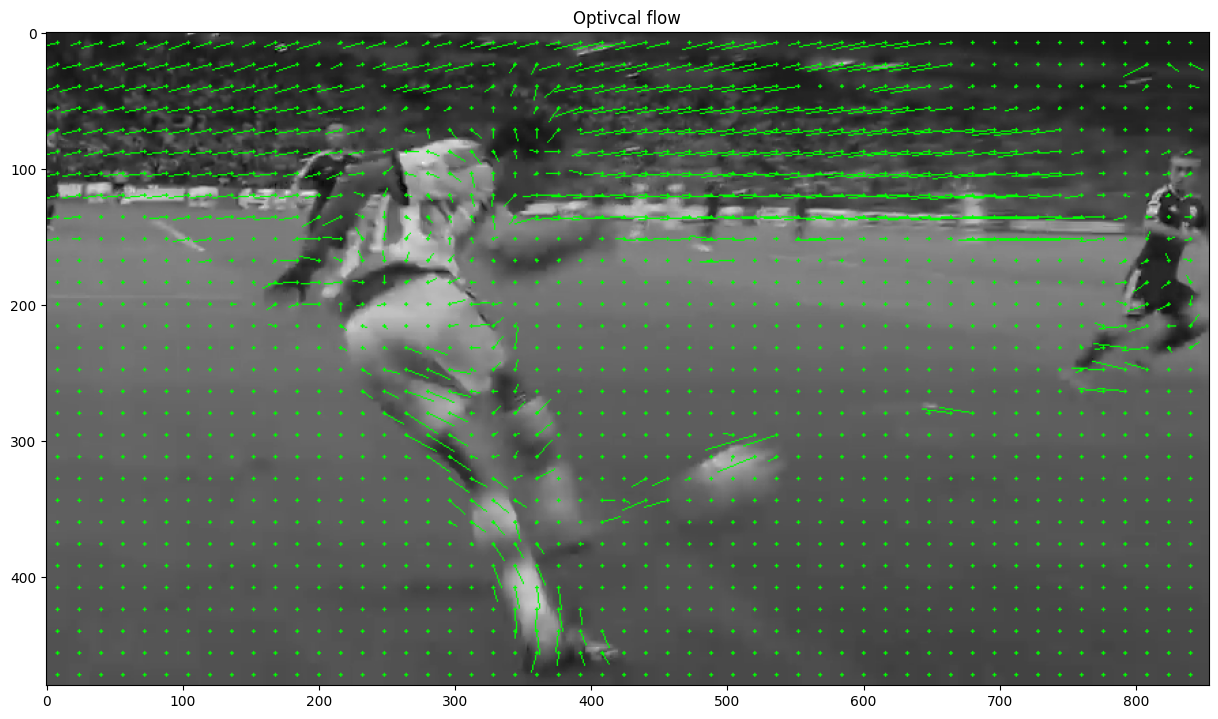

In [9]:
plt.figure(figsize=[15,15])
plt.imshow(vis)
plt.title("Optivcal flow")
plt.show()

#### Zadanie 1b
Zbadaj wpływ parametru `winsize` na działanie metody.

**larger values increase the algorithm robustness to image noise and give more chances for fast motion detection, but yield more blurred motion field.**

In [10]:
def calcOpticFlow(winsize):
    flow = cv2.calcOpticalFlowFarneback(
        prev=f1_gray,
        next=f2_gray,
        flow=None,
        pyr_scale=0.5,
        levels=3,
        winsize=winsize,
        iterations=3,
        poly_n=5,
        poly_sigma=1.2,
        flags=0
    )
    return flow

In [11]:
winsizes = [5, 15, 25, 35]

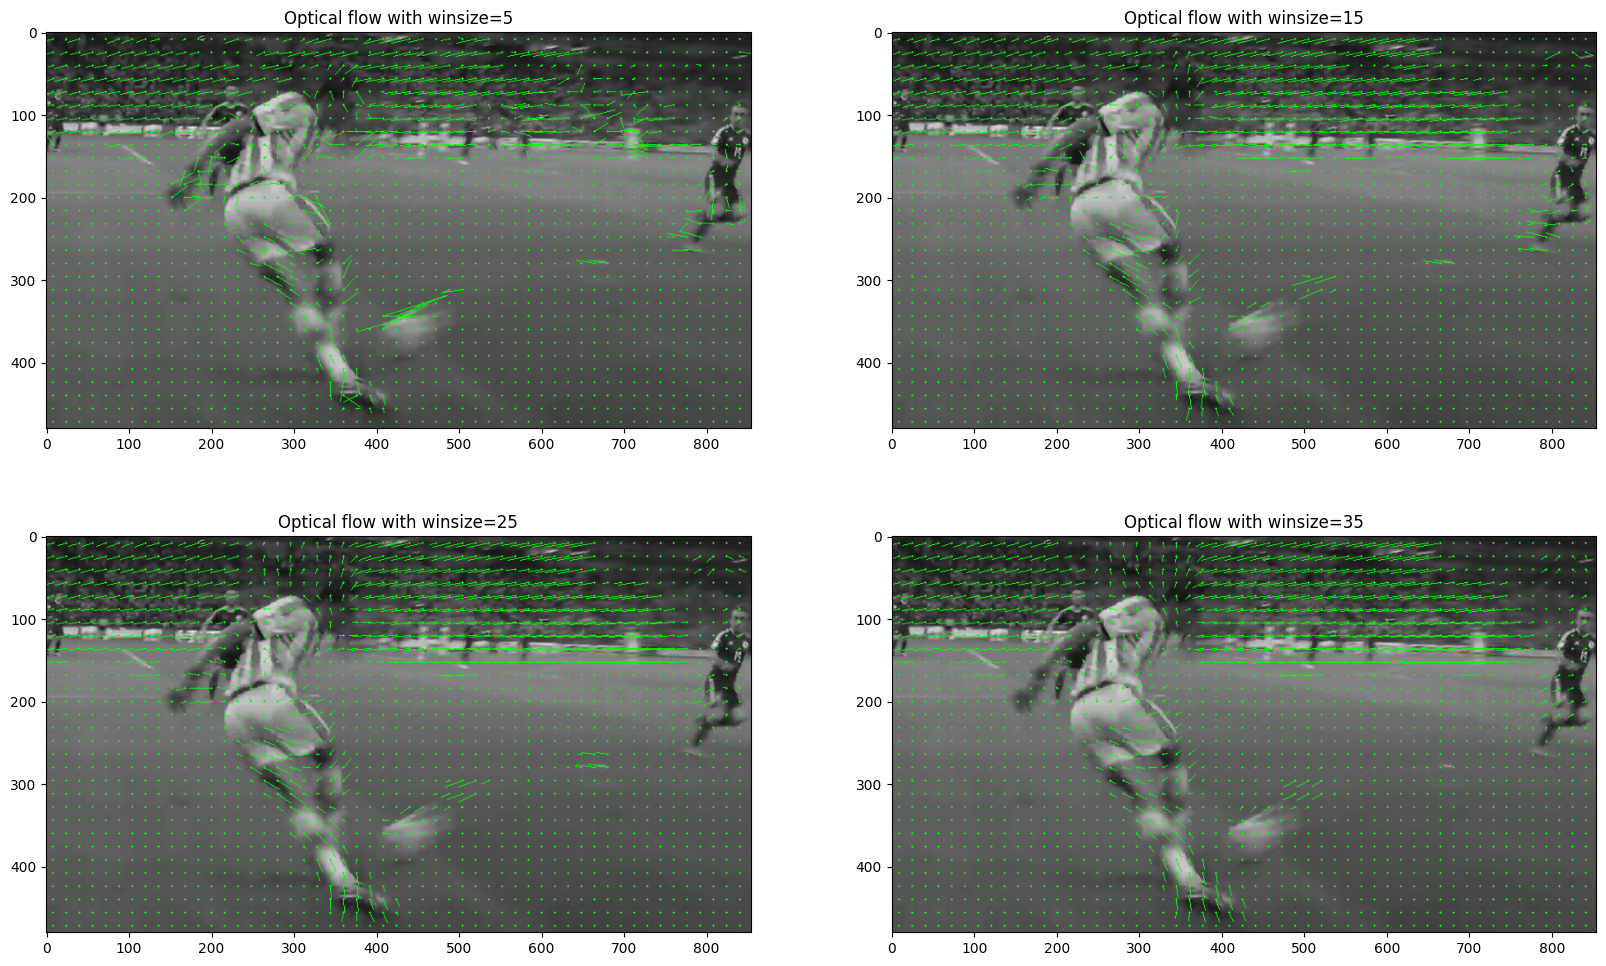

In [12]:
plt.figure(figsize=[20,12])
for i, winsize in enumerate(winsizes):
    flow = calcOpticFlow(winsize)
    vis = draw_flow(f1_gray, flow)
    plt.subplot(2, 2, i+1)
    plt.imshow(vis)
    plt.title(f"Optical flow with winsize={winsize}")

Komentarz 1:
Wyższe wartości są bardziej odporne na szum, jedak zbyt wysokie mogą powodować, że nie zostanie on wykryty.

---

### Zadanie 2

Powtórz powyższy eksperyment na materiale `shot.mp4` (przewiń materiał do momentu natychmiast po uderzeniu białej bili, ok. 20-25 klatek; framerate wynosi tu ok. 15fps).  
*Czy algorytm działa tak samo dobrze? Dlaczego? Co jest ograniczeniem metody?*

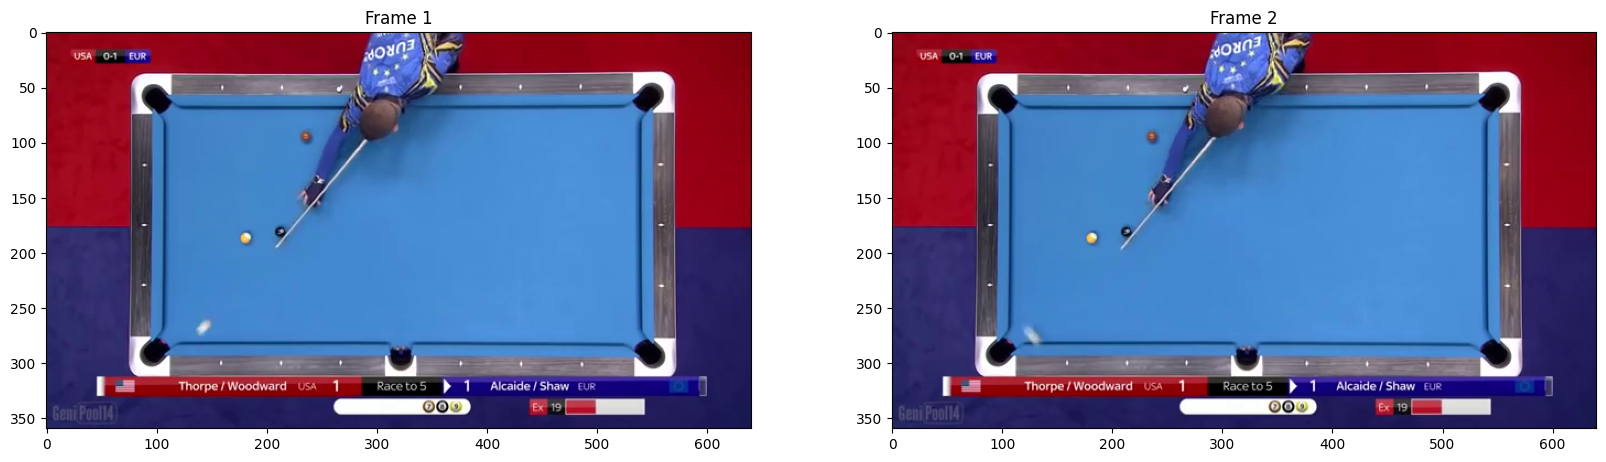

In [13]:
cap = cv2.VideoCapture("dane/shot.mp4")
for _ in range(22):
    r, frame = cap.read()

_, f1 = cap.read()
_, f2 = cap.read()

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(f1[..., ::-1])
plt.title("Frame 1")
plt.subplot(1, 2, 2)
plt.imshow(f2[..., ::-1])
plt.title("Frame 2")
plt.show()

In [14]:
f1_gray = cv2.cvtColor(f1, cv2.COLOR_BGR2GRAY)
f2_gray = cv2.cvtColor(f2, cv2.COLOR_BGR2GRAY)

In [15]:
winsizes = [1, 5, 15, 25]

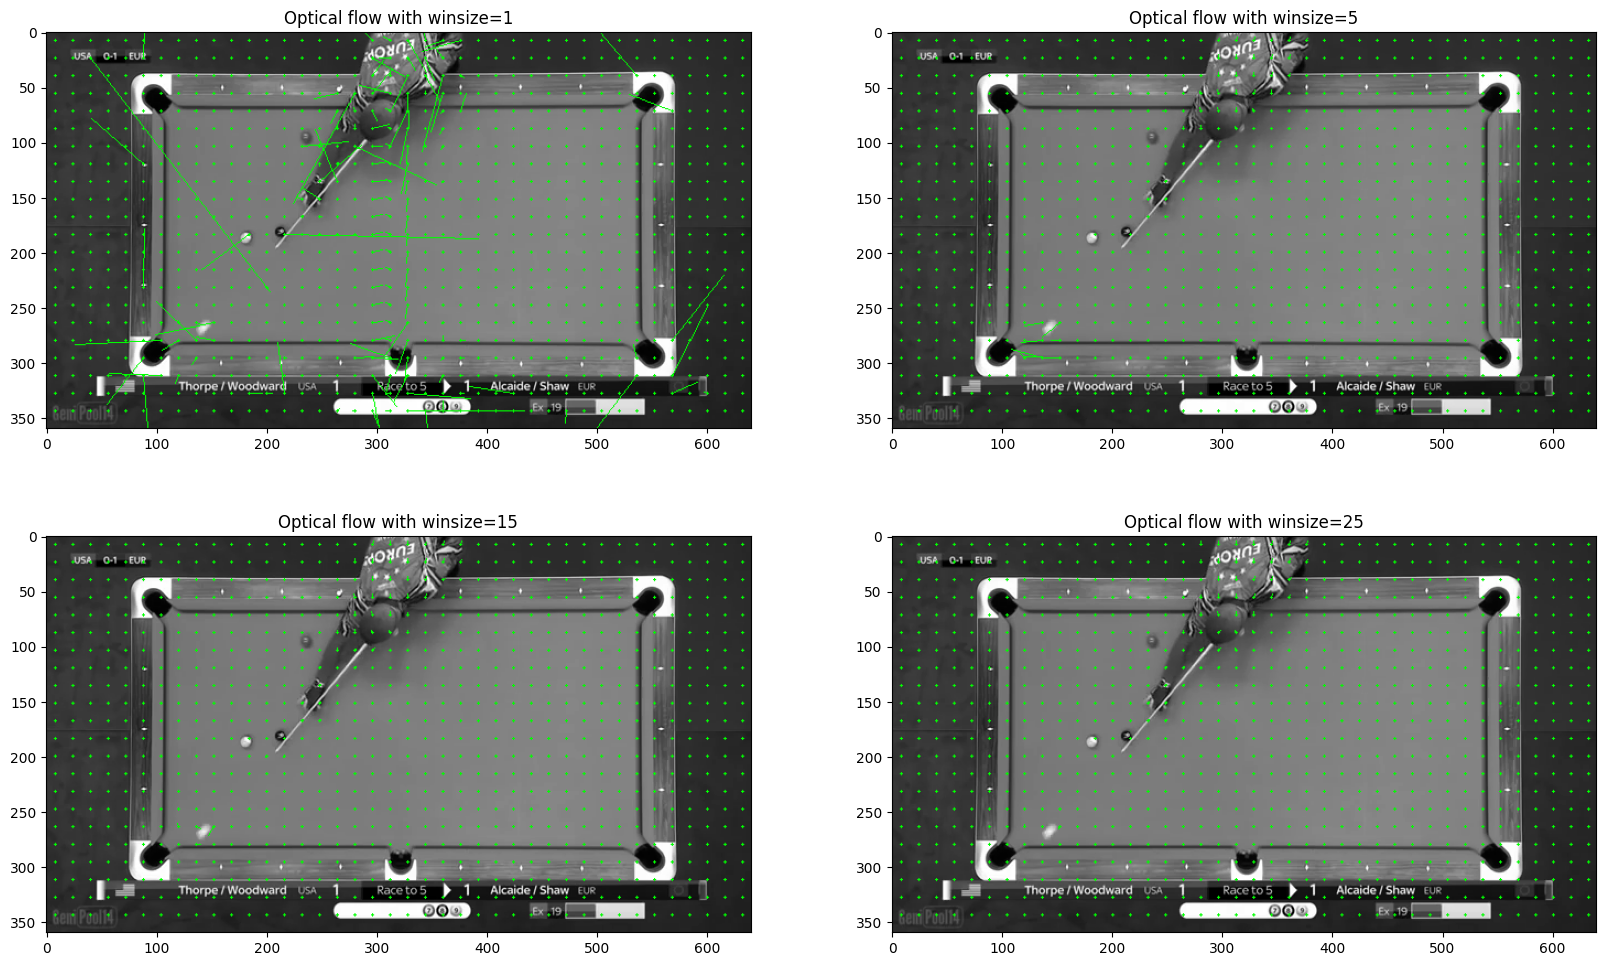

In [16]:
plt.figure(figsize=[20,12])
for i, winsize in enumerate(winsizes):
    flow = calcOpticFlow(winsize)
    vis = draw_flow(f1_gray, flow)
    plt.subplot(2, 2, i+1)
    plt.imshow(vis)
    plt.title(f"Optical flow with winsize={winsize}")

Komentarz 2:

...

### Zadanie dla chętnych

Powróć do takiego przypadku i konfiguracji algorytmu, dla którego uzyskane przez Ciebie wyniki były satysfakcjonujące. Przypomnij sobie zajęcia dotyczące np. segmentacji i wykorzystaj informację o przepływie optycznym do oddzielenia na obrazie obiektów od tła (metoda zupełnie dowolna).

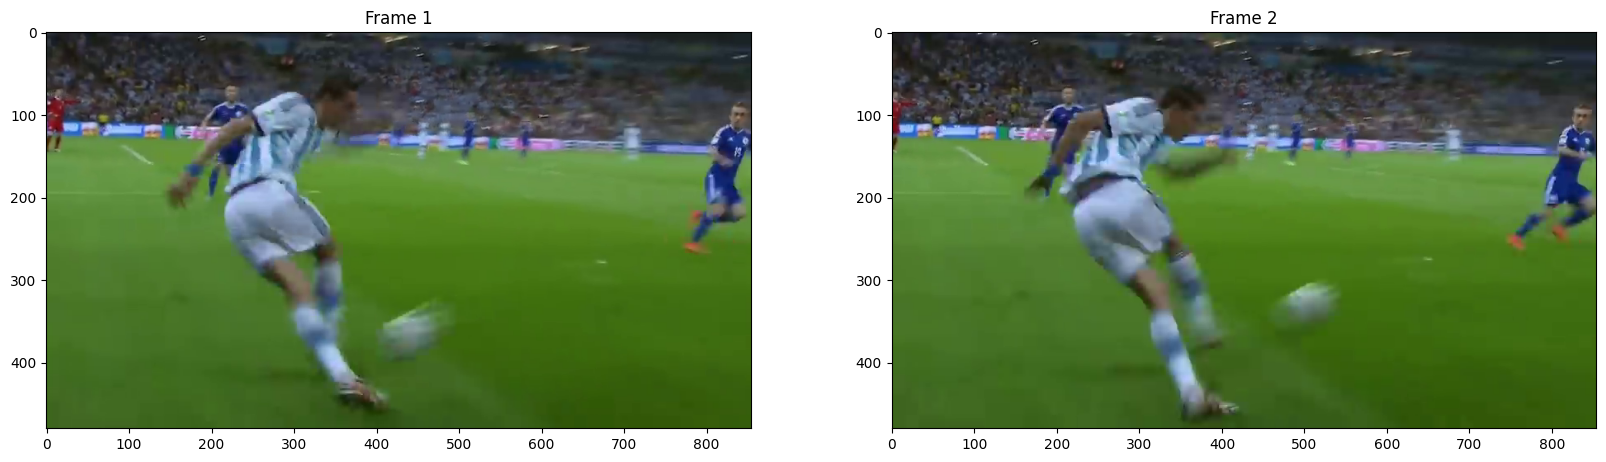

In [33]:
cap = cv2.VideoCapture("dane/back.mp4")
for _ in range(30):
    r, frame = cap.read()

_, f1 = cap.read()
_, f2 = cap.read()

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(f1[..., ::-1])
plt.title("Frame 1")
plt.subplot(1, 2, 2)
plt.imshow(f2[..., ::-1])
plt.title("Frame 2")
plt.show()

In [34]:
f1_gray = cv2.cvtColor(f1, cv2.COLOR_BGR2GRAY)
f2_gray = cv2.cvtColor(f2, cv2.COLOR_BGR2GRAY)

In [35]:
flow = calcOpticFlow(25)

In [36]:
magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

In [37]:
print(np.min(magnitude), np.max(magnitude))

3.586683e-10 32.310783


In [63]:
def get_mask(threshold: int = 1):
    motion_mask = magnitude > threshold
    motion_mask = motion_mask.astype(np.uint8)
    motion_visual = cv2.bitwise_and(f2_gray, f2_gray, mask=motion_mask)
    vis = draw_flow(f2_gray, flow)
    motion_visual_color = cv2.applyColorMap(motion_mask * 255, cv2.COLORMAP_JET)
    combined = cv2.addWeighted(vis, 0.7, motion_visual_color, 0.3, 0)
    plt.figure(figsize=[20, 10])
    plt.subplot(1, 3, 1)
    plt.imshow(vis)
    plt.title("Optical flow")
    plt.subplot(1, 3, 2)
    plt.imshow(motion_visual)
    plt.title("Motion mask")
    plt.subplot(1, 3, 3)
    plt.imshow(combined)
    plt.title("Combined")
    plt.show()

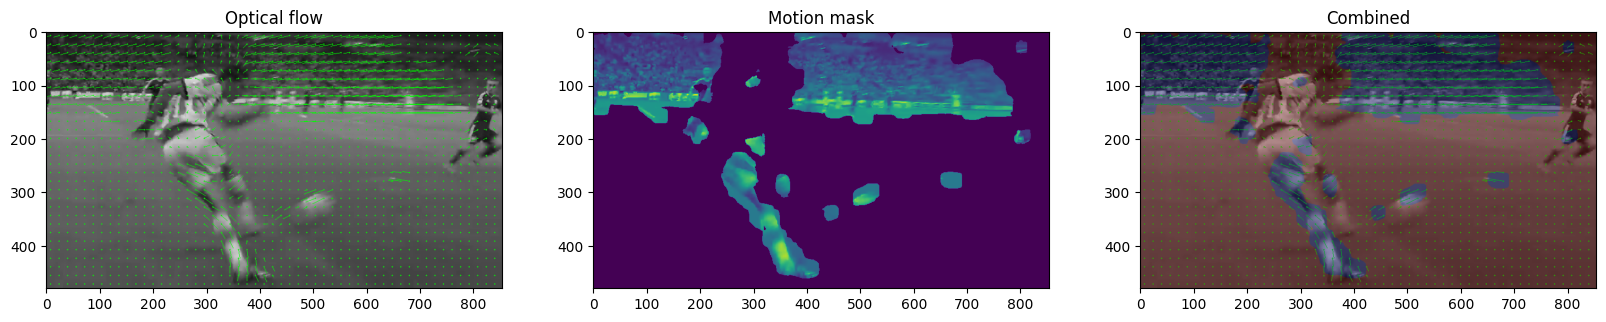

In [64]:
get_mask(10)


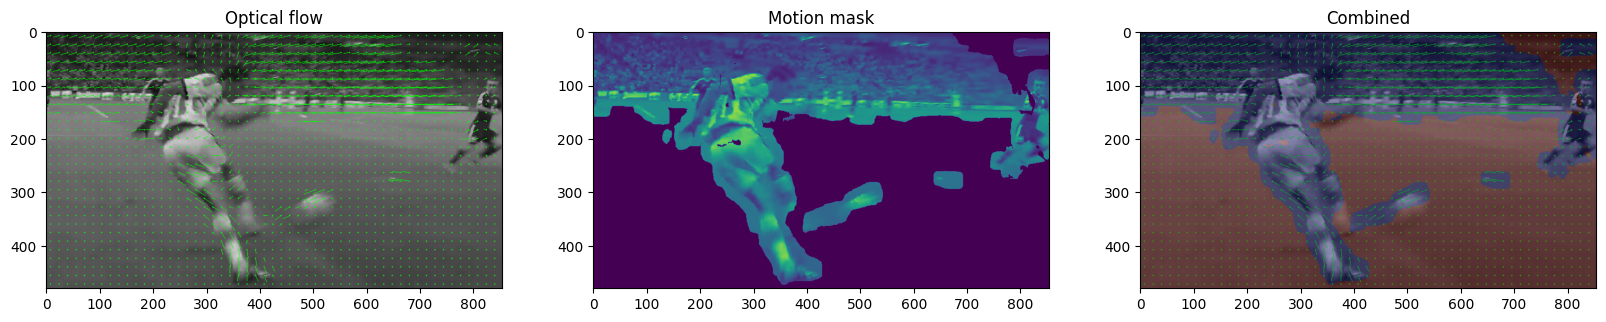

In [59]:
get_mask(1)

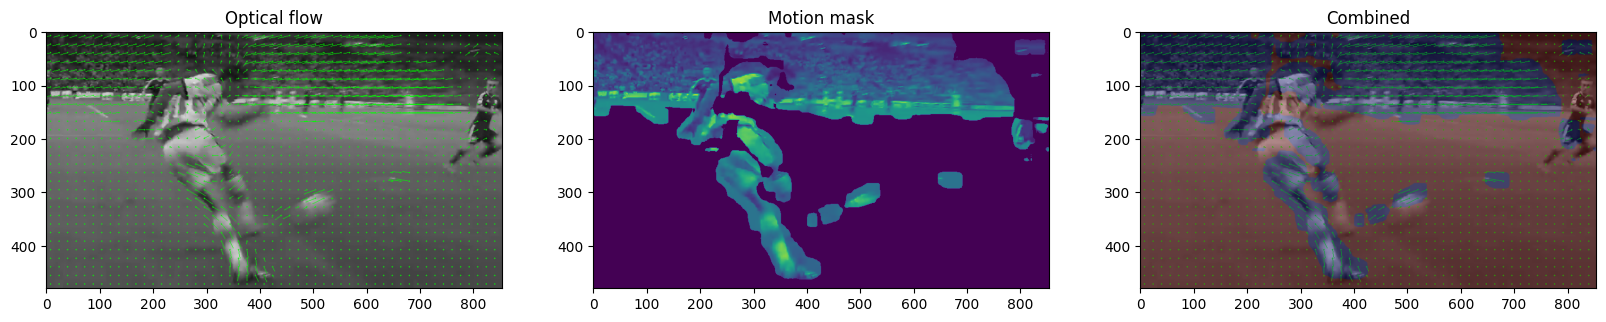

In [60]:
get_mask(5)